In [6]:
import urllib.request

urllib.request.urlretrieve("http://files.rcsb.org/download/1UBQ.pdb","1UBQ.pdb")
from Bio import PDB
parser=PDB.PDBParser()
struct=parser.get_structure("1ubq","1UBQ.pdb")
print(struct)
atom=list(struct.get_atoms())[0]
pp=PDB.PPBuilder()
polypeptide=pp.build_peptides(struct)
print(polypeptide)
polypeptide=polypeptide[0]
sequence=polypeptide.get_sequence()
str(sequence)

<Structure id=1ubq>
[<Polypeptide start=1 end=76>]


'MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG'

In [7]:
import pandas as pd
df = pd.read_csv('enzyme_classification.csv')

In [8]:
df.columns=['Amino acid', 'Class']
df.head()

,Amino acid,Class
0,1A2F,1
1,1A2V,1
2,1A4S,1
3,1A4Z,1
4,1A65,1


In [9]:
batch = df

In [11]:
#Getting amino acid sequence for all enzymes
import urllib.request
import warnings
import numpy as np
from Bio import PDB
warnings.filterwarnings("ignore")
counter = 0
sequences = np.array([])
failed = np.array([])
short = np.array([])
for x in batch['Amino acid']:
    counter += 1
    urllib.request.urlretrieve("http://files.rcsb.org/download/" + x +".pdb", x + ".pdb")
    parser=PDB.PDBParser()
    struct=parser.get_structure(x,x + '.pdb')
    atom=list(struct.get_atoms())[0]
    pp=PDB.PPBuilder()
    polypeptide=pp.build_peptides(struct)
    if len(polypeptide) == 0:
        failed = np.append(failed, counter-1)
        #print("Amino acid " + x + " not parsed correctly.")
    elif len(polypeptide) > 0:
        polypeptide=polypeptide[0]
        sequence=polypeptide.get_sequence()
        if len(str(sequence)) < 50:
            short = np.append(short, counter-1)
            #print("Amino acid " + x + "too short.")
        else:
            sequences = np.append(sequences, str(sequence))
    if counter == 1:
        print(str(sequence))
        print(counter, "amino acids processed.")
    if counter == 2:
        print(str(sequence))
        print(counter, "amino acids processed.")
        print ('...')
    if counter % 1000 == 0:
        print(counter, "amino acids processed.")

LVHVASVEKGRSYEDFQKVYNAIALKLREDDEYDNYIGYGPVLVRLAWHISGTWDKHDNTGGSYGGTYRFKKEFNDPSNAGLQNGFKFLEPIHKEFPWISSGDLFSLGGVTAVQEMQGPKIPWRCGRVDTPEDTTPDNGRLPDADKDAGYVRTFFQRLNMNDREVVALKGAHALGKTHLKNSGYEGPWGAANNVFTNEFYLNLLNEDWKLEKNDANNEQWDSKSGYMMLPTDYSLIQDPKYLSIVKEYANDQDKFFKDFSKAFEKLLENGITFPKDAPSPFIFKTLEEQGL
1 amino acids processed.
PARPAHPLDPLSTAEIKAATNTVKSYFAGKKISFNTVTLREPARKAYIQWKEQGGPLPPRLAYYVILEAGKPGVKEGLVDLASLSVIETRALETVQPILTVEDLCSTEEVIRNDPAVIEQCVLSGIPANEMHKVYCDPWTIGYDERWGTGKRLQQALVYYRSDEDDSQYSHPLDFCPIVDTEEKKVIFIDIPNRRRKVSKHKHANFYPKHMIEKVGAMRPEAPPINVTQPEGVSFKMTGNVMEWSNFKFHIGFNYREGIVLSDVSYNDHGNVRPIFHRISLSEMIVPYGSPEFPHQRKHALDIGEYGAGYMTNPLSLGCDCKGVIHYLDAHFSDRAGDPITVKNAVCIHEEDDGLLFKHSDFRDNFATSLVTRATKLVVSQIFTAAN
2 amino acids processed.
...
1000 amino acids processed.
2000 amino acids processed.
3000 amino acids processed.
4000 amino acids processed.
5000 amino acids processed.
6000 amino acids processed.
7000 amino acids processed.
8000 amino acids processed.
9000 amino acids processed.
10000 amino ac

In [12]:
def int_concatenate(sequence):
    vals = []
    for a in sequence:
        seq = [ord(x) for x in a]
        seq = [seq]
        vals += seq
    return vals 

In [13]:
#Converting all letters into integers
intvalues = int_concatenate(sequences)

In [14]:
len(sequences)

38784

In [15]:
dropped = batch
fail = np.append(failed, short)
fail = np.sort(fail)
fail = np.flip(fail)
for x in fail:
    dropped = dropped.drop(dropped.index[int(x)], axis=0)
dropped['Sequence'] = sequences


In [16]:
#Train-test split, preparing one hot encoding
import tensorflow as tf
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
x = np.array(intvalues)
y = dropped['Class']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,test_size=0.3)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

encoder=OneHotEncoder()
encoder.fit(np.array(list(x[0])).reshape(-1,1)) 
transformedtrain=np.array([encoder.transform(np.array(list(item[:50])).reshape(-1,1)).toarray() for item in x_train])
print(transformedtrain.shape)
transformedtest=np.array([encoder.transform(np.array(list(item[:50])).reshape(-1,1)).toarray() for item in x_test])
print(transformedtest.shape)

(27148,)
(11636,)
(27148,)
(11636,)
(27148, 50, 20)
(11636, 50, 20)


In [17]:
#RNN
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from keras.layers import Flatten, Activation
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

model = Sequential()
model.add(LSTM(64, input_shape=(50,20), return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(2, activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(2, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='tanh'))

from keras.utils import to_categorical
y_binarytrain = to_categorical(y_train)
y_binarytest = to_categorical(y_test)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
#Fitting model
model.summary()
final = model.fit(transformedtrain,
                  y_binarytrain, validation_data=(transformedtest, y_binarytest), epochs=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                21760     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 21        
Total params: 21,923
Trainable params: 21,923
Non-trainable params: 0
_________________________________________________________________
Instru

Epoch 50/200
27148/27148 [==============================] - 38s 1ms/step - loss: 0.0704 - acc: 0.6597 - val_loss: 0.0606 - val_acc: 0.7137
Epoch 51/200
27148/27148 [==============================] - 37s 1ms/step - loss: 0.0701 - acc: 0.6633 - val_loss: 0.0601 - val_acc: 0.7185
Epoch 52/200
27148/27148 [==============================] - 37s 1ms/step - loss: 0.0700 - acc: 0.6624 - val_loss: 0.0606 - val_acc: 0.7141
Epoch 53/200
27148/27148 [==============================] - 38s 1ms/step - loss: 0.0697 - acc: 0.6618 - val_loss: 0.0598 - val_acc: 0.7182
Epoch 54/200
27148/27148 [==============================] - 36s 1ms/step - loss: 0.0701 - acc: 0.6618 - val_loss: 0.0602 - val_acc: 0.7156
Epoch 55/200
27148/27148 [==============================] - 37s 1ms/step - loss: 0.0695 - acc: 0.6624 - val_loss: 0.0599 - val_acc: 0.7187
Epoch 56/200
27148/27148 [==============================] - 38s 1ms/step - loss: 0.0692 - acc: 0.6658 - val_loss: 0.0603 - val_acc: 0.7190
Epoch 57/200
27148/27148 [=

Epoch 109/200
27148/27148 [==============================] - 38s 1ms/step - loss: 0.0649 - acc: 0.6840 - val_loss: 0.0561 - val_acc: 0.7387
Epoch 110/200
27148/27148 [==============================] - 37s 1ms/step - loss: 0.0651 - acc: 0.6943 - val_loss: 0.0558 - val_acc: 0.7378
Epoch 111/200
27148/27148 [==============================] - 37s 1ms/step - loss: 0.0652 - acc: 0.6951 - val_loss: 0.0558 - val_acc: 0.7383
Epoch 112/200
27148/27148 [==============================] - 38s 1ms/step - loss: 0.0651 - acc: 0.6940 - val_loss: 0.0561 - val_acc: 0.7360
Epoch 113/200
27148/27148 [==============================] - 36s 1ms/step - loss: 0.0650 - acc: 0.6940 - val_loss: 0.0558 - val_acc: 0.7369
Epoch 114/200
27148/27148 [==============================] - 37s 1ms/step - loss: 0.0645 - acc: 0.7002 - val_loss: 0.0558 - val_acc: 0.7372
Epoch 115/200
27148/27148 [==============================] - 38s 1ms/step - loss: 0.0646 - acc: 0.6955 - val_loss: 0.0556 - val_acc: 0.7369
Epoch 116/200
27148/

27148/27148 [==============================] - 36s 1ms/step - loss: 0.0629 - acc: 0.7086 - val_loss: 0.0543 - val_acc: 0.7430
Epoch 168/200
27148/27148 [==============================] - 37s 1ms/step - loss: 0.0627 - acc: 0.7085 - val_loss: 0.0545 - val_acc: 0.7466
Epoch 169/200
27148/27148 [==============================] - 38s 1ms/step - loss: 0.0625 - acc: 0.7107 - val_loss: 0.0543 - val_acc: 0.7448
Epoch 170/200
27148/27148 [==============================] - 36s 1ms/step - loss: 0.0630 - acc: 0.7066 - val_loss: 0.0544 - val_acc: 0.7442
Epoch 171/200
27148/27148 [==============================] - 37s 1ms/step - loss: 0.0630 - acc: 0.7054 - val_loss: 0.0541 - val_acc: 0.7451
Epoch 172/200
27148/27148 [==============================] - 37s 1ms/step - loss: 0.0628 - acc: 0.7102 - val_loss: 0.0543 - val_acc: 0.7438
Epoch 173/200
27148/27148 [==============================] - 38s 1ms/step - loss: 0.0626 - acc: 0.7057 - val_loss: 0.0541 - val_acc: 0.7435
Epoch 174/200
27148/27148 [=======

In [19]:
#One hot encoding
encoder=OneHotEncoder()
encoder.fit(np.array(list(x[0])).reshape(-1,1)) 
transformed2=np.array([encoder.transform(np.array(list(item[:50])).reshape(-1,1)).toarray() for item in x_test])
y_binary2 = to_categorical(y_test)
score, acc = model.evaluate(transformed2, y_binary2)
print('Test score:', score)
print('Test accuracy:', acc)

11636/11636 [==============================] - 3s 229us/step
Test score: 0.05399440463802666
Test accuracy: 0.7463905122239961


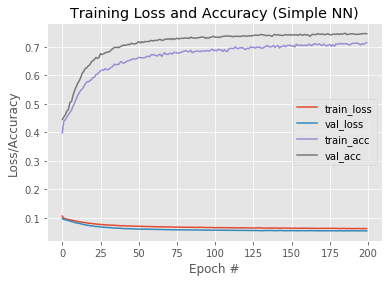

In [28]:
#Plotting accuracies
matplotlib.use("Agg")
import matplotlib.pyplot as plt
%matplotlib inline
N = np.arange(0, 200)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, final.history["loss"], label="train_loss")
plt.plot(N, final.history["val_loss"], label="val_loss")
plt.plot(N, final.history["acc"], label="train_acc")
plt.plot(N, final.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend();
plt.savefig('Loss and accuracy')